In [1]:
#https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.020502

# Import necessary libraries
# These libraries include numpy for numerical calculations, scipy for scientific computations,
# matplotlib for plotting, and Qiskit for quantum circuit operations.
import numpy as np
from numpy import linalg as LA
import scipy.io
import matplotlib.pyplot as plt
import math

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile

from IPython.display import clear_output

# Define the number of qubits and constants J and Delta
num_q = 8  # Number of qubits
J = 1  # Interaction strength
Delta = 1.5  # Transverse field strength

# Initialize lists to store the Pauli operators
List_1 = []  # List to store the ZZ interaction terms
op = "" 

# Construct the ZZ interaction Hamiltonian terms
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"  # Add identity operators for qubits before the pair
    op += "ZZ"  # Add the ZZ interaction for qubits i and i+1
    for k in range(i+1, num_q-1):
        op += "I"  # Add identity operators for qubits after the pair
    List_1.append(op)  # Append the constructed operator string to List_1

List_1.reverse()  # Reverse the list to maintain desired order
H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  # Create SparsePauliOp for ZZ interactions

# Initialize list to store the X operator terms
List_2 = []
op = ""

# Construct the transverse field X Hamiltonian terms
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"  # Add identity operators for qubits before i
    op += "X"  # Add the X operator for qubit i
    for k in range(i+1, num_q):
        op += "I"  # Add identity operators for qubits after i
    List_2.append(op)  # Append the constructed operator string to List_2

# Create SparsePauliOp for X operators with strength Delta
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

# Combine the two Hamiltonians to form the total Hamiltonian H
H = SparsePauliOp.sum([H1, H2])

# Convert the SparsePauliOp into a matrix form for diagonalization
Hmat = Operator(H)
Hmat = Hmat.data  # Extract the numerical matrix data

# Diagonalize the Hamiltonian to find eigenvalues and eigenvectors
e, v = LA.eig(Hmat)
min_index = np.argmin(e)  # Find the index of the minimum eigenvalue (ground state)
v_min = v[:, min_index]  # Extract the eigenvector corresponding to the ground state
ground_e = np.min(e)  # Get the ground state energy

# Print details about the Hamiltonian and the ground state energy
print(H[-1])  # Print the last Pauli term of the Hamiltonian
print(np.min(e))  # Print the minimum eigenvalue (ground state energy)
print(H.size)  # Print the number of Pauli terms in the Hamiltonian
print(H.paulis[0])  # Print the first Pauli term in the Hamiltonian

SparsePauliOp(['IIIIIIIX'],
              coeffs=[1.5+0.j])
(-13.191404952188934+0j)
15
IIIIIIZZ


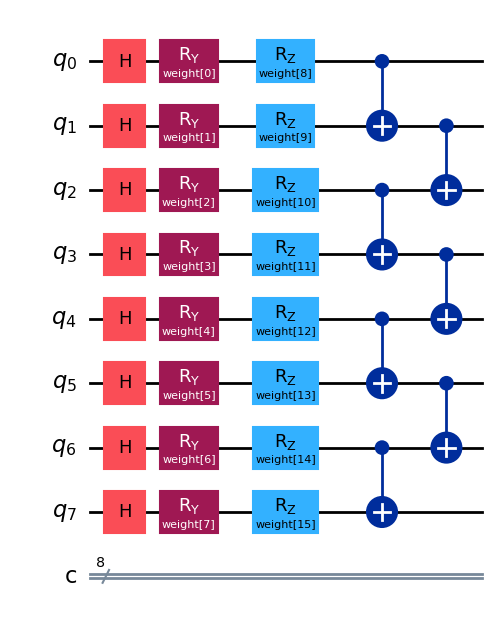

In [2]:
"""circuit construction"""

# Define the number of layers and parameters for the circuit
layer = 1  # Number of layers in the circuit
num_p = 2 * layer * num_q  # Total number of parameters needed

# Create a parameter vector to hold the parameters for the circuit
weights = ParameterVector("weight", num_p)

def circuit_ex(weights):
    # Initialize a quantum circuit with num_q qubits and num_q classical bits
    circ = QuantumCircuit(num_q, num_q)
    
    # Apply a Hadamard gate to each qubit to create a superposition state
    for j in range(num_q):
        circ.h(j)
    
    # Apply parameterized layers to the circuit
    for i in range(layer):
        # Apply parameterized Ry and Rz rotations to each qubit
        for j in range(num_q):
            circ.ry(weights[2 * i * num_q + j], j)  # Ry rotation on qubit j
        for j in range(num_q):
            circ.rz(weights[2 * i * num_q + num_q + j], j)  # Rz rotation on qubit j
        
        # Apply CNOT gates for entanglement
        for j in range(int(num_q / 2)):
            circ.cx(2 * j, 2 * j + 1)  # CNOT between qubit pairs (0,1), (2,3), etc.
        for j in range(int(num_q / 2) - 1):
            circ.cx(2 * j + 1, 2 * j + 2)  # CNOT between qubit pairs (1,2), (3,4), etc.
        
    return circ  # Return the constructed circuit

qc=circuit_ex(weights)
qc.draw('mpl')

In [3]:
# Initialize the AerSimulator from Qiskit, which is used to simulate the quantum circuits
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):
    """
    Estimate the loss of the quantum circuit for a given set of weights.

    Parameters:
    WEIGHTS: np.array - The parameters for the circuit.
    SHOTS: int - The number of measurement shots for the simulation.

    Returns:
    float - The estimated loss value.
    """
    estimate = 0  # Initialize the loss estimate
    qc = circuit_ex(WEIGHTS)  # Create a quantum circuit with the given weights
    qc = transpile(qc, simulator)  # Transpile the circuit for the simulator

    # Prepare for measurement
    ind = list(range(num_q))  # Indices for qubits to be measured
    rind = ind
    rind.reverse()  # Reverse the indices to match Qiskit's big-endian convention
    qc.measure(ind, rind)  # Add measurement operations to the circuit

    # Run the simulation
    result = simulator.run(qc, shots=SHOTS, memory=True).result()
    c = result.get_memory(qc)  # Retrieve the output distribution of 0s and 1s

    # Calculate the loss estimate based on the simulation results
    for i in range(SHOTS):
        for j in range(num_q-1):
            # Add 1 if adjacent qubits are the same, subtract 1 if they differ
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1
    estimate = J * estimate / SHOTS  # Normalize the estimate

    # Additional estimation step with Hadamard gates applied
    estimate_1 = 0
    qc = circuit_ex(WEIGHTS)
    for i in range(num_q):
        qc.h(i)  # Apply a Hadamard gate to each qubit
    qc = transpile(qc, simulator)
    qc.measure(ind, rind)
    result = simulator.run(qc, shots=SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    estimate_1 = Delta * estimate_1 / SHOTS  # Normalize the second estimate

    return estimate + estimate_1  # Return the combined estimate

def parameter_shift(WEIGHTS, INDEX, SHOTS):
    """
    Calculate the gradient of the loss function using the parameter shift rule.

    Parameters:
    WEIGHTS: np.array - The parameters for the circuit.
    INDEX: int - The index of the parameter to shift.
    SHOTS: int - The number of measurement shots for the simulation.

    Returns:
    float - The gradient with respect to the parameter at INDEX.
    """
    identity = np.identity(num_p)
    direction_index = np.pi/2 * identity[:, INDEX]  # Create a shift vector

    # Estimate the loss with positive and negative parameter shifts
    g_p = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)  
    g_m = estimate_loss((WEIGHTS - direction_index.flatten()), SHOTS)
    g = 0.5 * (g_p - g_m)  # Calculate the gradient using the parameter shift rule
    return g

def expectation_loss(WEIGHTS):
    """
    Calculate the expectation value of the Hamiltonian for a given set of weights.

    Parameters:
    WEIGHTS: np.array - The parameters for the circuit.

    Returns:
    float - The expectation value of the Hamiltonian.
    """
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()  # Save the state vector of the circuit
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)  # Retrieve the state vector
    psi = np.asarray(state_vector)
    
    Hpsi = Hmat.dot(psi)  # Apply the Hamiltonian to the state
    expectation = np.inner(np.conjugate(psi), Hpsi)  # Calculate the expectation value
    return np.real(expectation)  # Return the real part of the expectation

def fidelity(WEIGHTS):
    """
    Calculate the fidelity between the state generated by the circuit and the ground state.

    Parameters:
    WEIGHTS: np.array - The parameters for the circuit.

    Returns:
    float - The fidelity value.
    """
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()  # Save the state vector of the circuit
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)  # Retrieve the state vector
    psi = np.asarray(state_vector)
    
    return np.absolute(np.vdot(psi, v_min))**2  # Calculate and return the fidelity


Loss and Fidelity: -8.321038702668243 0.06277851675158586


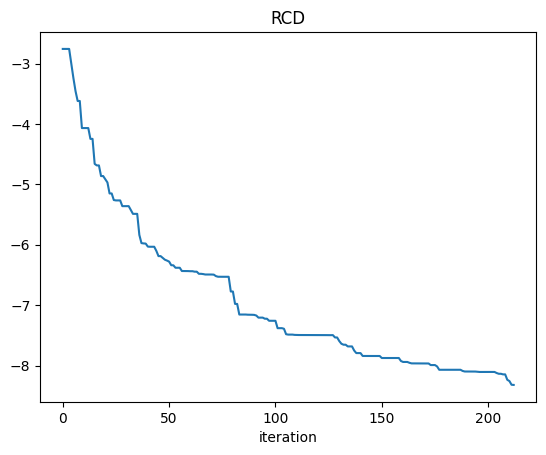

KeyboardInterrupt: 

In [4]:
""" Optimization Phase """

""" Initialization of Weights """
# Load initial weights from a .mat file
mat = scipy.io.loadmat('w0')
w0 = mat['w0']

# Initialize weights for the parameters, starting with zeros
initial_weights = np.zeros(num_p)
initial_weights[:10] = w0.flatten()  # Load some initial weights from the file into the first 10 positions

# Define constants for the optimization process
T = 2000  # Number of iterations (time steps) for the optimization
n_shot = 1000  # Number of shots (samples) per simulation run

# Initialize identity matrix for parameter manipulation
identity = np.identity(num_p)

# Initialize matrices to store results
num_results = 1  # Number of independent optimization runs
cost_mat = np.empty((0, T), int)
fidelity_mat = np.empty((0, T), int)
weight_mat = np.empty((0, T), int)

# Initialize variables for storing fidelity and loss
F = 0
loss = 0 

# Perform optimization for each run
for k in range(num_results):
    cost = []  # List to store cost (loss) values
    cost_f = []  # List to store fidelity values
    Weights = []  # List to store weight vectors
    
    weights = initial_weights  # Start with the initial weights
    iteration = 0  # Track the current iteration
    
    while iteration < T:
        a = 0.1  # Learning rate (step size)
        iteration += 1  # Increment the iteration counter
        
        # Choose a random parameter to update
        index = np.random.randint(0, num_p, 1)
        
        # Compute the gradient of the loss with respect to the chosen parameter
        gradient = parameter_shift(weights, index, n_shot)
        
        # Update the weights using gradient descent
        v = identity[:, index].flatten()
        weights = weights - a * (gradient * v)
        
        Weights.append(weights)  # Store the updated weights
        
        # Calculate the expectation loss and fidelity for the current weights
        loss = expectation_loss(weights)
        F = fidelity(weights)
        
        # Display progress and update plots
        clear_output(wait=True)
        print('Loss and Fidelity:', loss, F)
        plt.plot(cost)
        plt.xlabel('iteration')
        plt.title('RCD')
        plt.show()
        
        # Record the loss and fidelity
        cost.append(loss.flatten())
        cost_f.append(F.flatten())
    
    # Convert results to numpy arrays for saving
    Cost = np.asarray(cost)
    WEIGHTS = np.asarray(Weights)
    FIDELITY = np.asarray(cost_f)
    
    # Append results to the matrices
    cost_mat = np.append(cost_mat, np.transpose(Cost), axis=0)
    weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis=0)
    fidelity_mat = np.append(fidelity_mat, np.transpose(FIDELITY), axis=0)
    
# Save the results to .mat files for further analysis
scipy.io.savemat('rcdm_loss_1.mat', {'rcdm_loss_1': cost_mat})
scipy.io.savemat('rcdm_weight_1.mat', {'rcdm_weight_1': weight_mat})
scipy.io.savemat('rcdm_fidelity_1.mat', {'rcdm_fidelity_1': fidelity_mat})
